# Semantic Segmentation with Captum

In this tutorial, we demonstrate applying Captum to semantic segmentation task, to understand what pixels and regions contribute to the labeling of a particular class. We explore applying GradCAM as well as Feature Ablation to a pretrained Fully-Convolutional Network model with a ResNet-101 backbone.

  **Note:** Before running this tutorial, please install torchvision and PIL.

Initial Imports:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

We can now load the pre-trained segmentation model from torchvision, which is trained on a subset of COCO Train 2017 and define input preprocessing transforms.

In [2]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()

In [3]:
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize(640), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])


We define a few helper methods to visualize segmentation results. 
(Source: https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In [4]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=21):  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

Let us now obtain an image from the COCO training set to evaluate and interpret the segmentation model.

In [5]:
!wget -nv --directory-prefix=img/segmentation/ https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg

2020-06-24 12:16:37 URL:https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg [110417] -> "img/segmentation/8862358875_eecba9fb10_z.jpg.9" [1]


Display original image

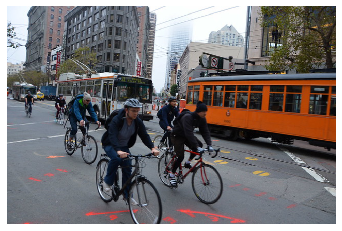

In [6]:
img = Image.open("img/segmentation/8862358875_eecba9fb10_z.jpg")
preproc_img = preprocessing(img)
plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off'); plt.show()


We now normalize the input image and compute and visualize the image segmentation output.

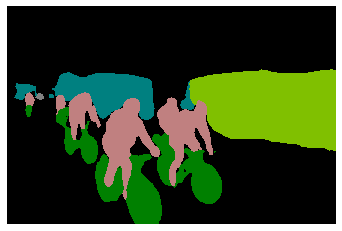

In [7]:
# Normalize image and compute segmentation output
normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp.requires_grad = True
out = fcn(normalized_inp)['out']

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb); plt.axis('off'); plt.show()


We see that the segmentation model has identified regions including humans, bicicyles, trucks, and cars. We will now interpret the model using Captum to understand what pixels contribute to these predictions. 

## Interpreting with Captum

A challenge with applying Captum to segmentation models is that we need to attribute with respect to a single scalar output, such as a target logit in classification cases. With segmentation models, the model output is the size of the input image. 

One way to compute attribution is with respect to a particular pixel output score for a given class. This is the right approach if we want to understand the influences for a particular pixel, but we often want to understand the prediction of an entire segment, as opposed to attributing each pixel independently.

This can be done in a few ways, the simplest being summing the output logits of each channel, corresponding to a total score for each segmentation class, and attributing with respect to the score for the particular class. This approach is simple to implement, but could result in misleading attribution when a pixel is not predicted as a certain class but still has a high score for that class. Based on this, we sum only the scores corresponding to pixels that are predicted to be a particular class (argmax class) and attribute with respect to this sum. We define a wrapper function that performs this, and can use this wrapper for attribution instead of the original model.

In [8]:
"""
This wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
def agg_segmentation_wrapper(inp):
    model_out = fcn(inp)['out']
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))


# Alternate wrapper, simply summing each output channel
# def wrapper(inp):
#   return fcn(inp)['out'].sum(dim=(2,3))


We can now construct a LayerGradCAM attribution object using the wrapper, as well as the desired convolution layer for attribution. Generally, the final convolution layer is used for GradCAM attribution.

In [9]:
lgc = LayerGradCam(agg_segmentation_wrapper, fcn.backbone.layer4[2].conv3)

We can now compute LayerGradCAM attributions by providing the preprocessed input and the desired target segmentation class (between 0 and 20), which is the index of the output.

In this example, we attribute with respect to target=6, which corresponds to bus. See the decode_segmap helper method for a mapping of target class indices to text.

In [10]:
gc_attr = lgc.attribute(normalized_inp, target=6)

We can first confirm that the Layer GradCAM attributions match the dimensions of the layer activations. We can obtain the intermediate layer activation using the LayerActivation attribution method.

In [11]:
la = LayerActivation(agg_segmentation_wrapper, fcn.backbone.layer4[2].conv3)
activation = la.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 640, 966])
Layer Activation Shape: torch.Size([1, 2048, 80, 121])
Layer GradCAM Shape: torch.Size([1, 1, 80, 121])


We can now visualize the Layer GradCAM attributions using the Captum visualization utilities.

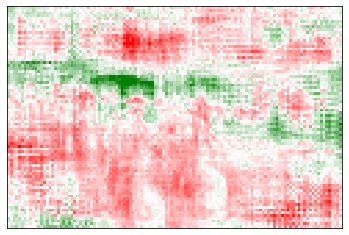

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16fe46e670>)

In [12]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

We'd like to understand this better by overlaying it on the original image. In order to do this, we need to upsample the layer GradCAM attributions to match the input size.

In [13]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,normalized_inp.shape[2:])
print("Upsampled Shape:",upsampled_gc_attr.shape)

Upsampled Shape: torch.Size([1, 1, 640, 966])


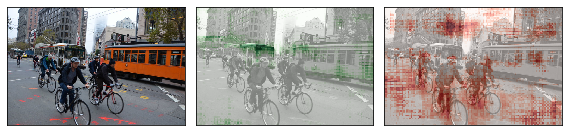

(<Figure size 576x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f16fdfe4100>,
       dtype=object))

In [14]:
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=preproc_img.permute(1,2,0).numpy(),signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"])

We can now attribute using a perturbation-based method, Feature Ablation to interpret the model in a different way. The idea of feature ablation is to ablate each feature by setting it equal to some baseline value (e.g. 0) and compute the difference in output with and without the feature. This can be done pixel-wise, but that can often by computationally intensive for large images. We also provide the option to group features and ablate them together. In this case, we can group pixels based on their segmentation class to understand how the presence of each class affects a particular output.

To better understand how this ablation works, let us consider ablating the train class of the segmentation output and visualize the result.

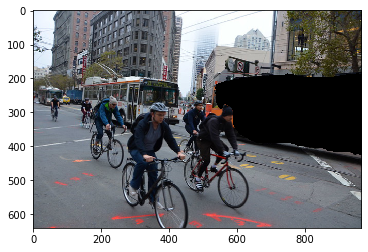

In [15]:
img_without_train = (1 - (out_max == 19).float())[0].cpu() * preproc_img
plt.imshow(img_without_train.permute(1,2,0))

Feature ablation performs this process on each segment, comparing the output with and without ablating the segment. All pixels in the segment have the same attribution score corresponding to the change in output. This can be done using the FeatureAblation attribution class. We provide a feature mask defining the desired grouping of pixels (based on output class of each pixel). The perturbations_per_eval argument controls the number of perturbations processed in one batch, this may need to be set to a lower value if limited memory is available.
**Note**: This may take up to a few minutes to complete.

In [16]:
fa = FeatureAblation(agg_segmentation_wrapper)
fa_attr = fa.attribute(normalized_inp, feature_mask=out_max, perturbations_per_eval=2, target=6)

We can now visualize the attributions based on Feature Ablation.

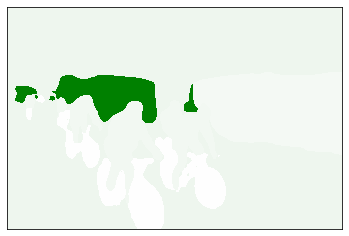

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16ff4f6940>)

In [17]:
viz.visualize_image_attr(fa_attr[0].cpu().detach().permute(1,2,0).numpy(),sign="all")

Clearly, the bus region is most salient as expected, since that is the target we are interpreting. To better visualize the relative importance of the remaining regions, we can set the attributions of the bus area to 0 and visualize the remaining area.

In [18]:
fa_attr_without_max = (1 - (out_max == 6).float())[0] * fa_attr


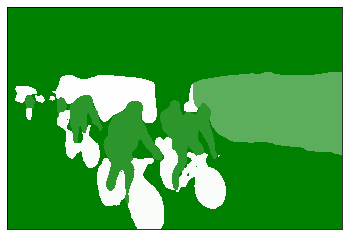

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16fdf4ab50>)

In [19]:
viz.visualize_image_attr(fa_attr_without_max[0].cpu().detach().permute(1,2,0).numpy(),sign="all")

Between the remaining regions, it seems that the background and humans contribute positively to the bus prediction, as does the train. Ablating the bicycle appears to have no effect on the bus prediction.